In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
import scipy.integrate as integrate
from scipy.stats import norm
# to print plots inline
%matplotlib inline

In [2]:
rho = 0.7605
mu = 0.0
sigma_eps = 0.213
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))

# Compute cut-off values
N = 9  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu

# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
z_grid=np.exp(z_grid)
print('Grid points = ', z_grid)

# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]


Grid points =  [ 0.57170087  0.72611947  0.82344962  0.91128377  1.          1.09735302
  1.21440337  1.37718384  1.74916648]


In [3]:
import time

# specify parameters
alpha_k = 0.297
alpha_l = 0.65
delta = 0.154
psi1 = 0.03
w = 0.7
r= 0.04
z = 1
betafirm = (1 / (1 + r))

In [4]:
dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

In [5]:
@jit
def e_inv(z_grid):
    e = np.zeros((len(z_grid),sizek, sizek))
    for h in range(len(z_grid)):
        op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *\
          ((kvec ** alpha_k) ** (1 / (1 - alpha_l)))) *\
          (z_grid[h] ** (1 / (1 - alpha_l)))
        for i in range(sizek):
            for j in range(sizek):
                    e[h, i, j] = (op[i] - kvec[j] + ((1 - delta) * kvec[i]) -
                               (psi1 * kvec[i]))
    return e

@jit
def e_no_inv(z_grid):
    e = np.zeros((len(z_grid),sizek))
    for h in range(len(z_grid)):
        op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *\
          ((kvec ** alpha_k) ** (1 / (1 - alpha_l)))) *\
          (z_grid[h] ** (1 / (1 - alpha_l)))
        for i in range(sizek):
            for j in range(sizek):
                    e[h, :] = (op)
    return e

@jit
def find_vmat(V,ez,sizek,z_grid,betafirm,inv=True):
    if inv == True:
        Vmat = np.zeros((len(z_grid), sizek, sizek))  # initialize Vmat matrix
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k'
                for k in range(len(z_grid)):
                        Vmat[k, i, j] = ez[k, i, j] + betafirm * V[k][j]
    else:
        Vmat = np.zeros((len(z_grid),sizek))
        for i in range(sizek):
            for j in range(len(z_grid)):
                if i < int(dens):
                    Vmat[j,i] = ez[j,i] + betafirm * V[j,i]
                else:
                    Vmat[j,i] = ez[j,i] + betafirm * V[j,i-dens]
    return Vmat

In [17]:
VFtol = 1e-6
VFmaxiter = 3000
V2 = np.zeros((len(z_grid),sizek))  # initial guess at value function
PF2 = np.zeros((len(z_grid),sizek))
V_inv = np.zeros((len(z_grid),sizek))
PF_inv = np.zeros((len(z_grid),sizek))
V_no_inv = np.zeros((len(z_grid),sizek))
Vstore2 = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
start_time = time.clock()
VFdist = 7.0
VFiter = 1
ez_inv = e_inv(z_grid)
ez_no_inv = e_no_inv(z_grid)
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = np.copy(V2)
    
    #Case with investment
    
    Vmat_inv = find_vmat(V2,ez_inv,sizek,z_grid,betafirm)
    Vmat_noinv = find_vmat(V2,ez_no_inv,sizek,z_grid,betafirm,inv=False)
    for l in range(len(z_grid)):
        weights = pi[l]
        Vmat1 = np.average(Vmat_inv,axis=0,weights=weights)
        Vstore2[:, VFiter] = V2[l].reshape(sizek,)  # store value function at each
        # iteration for graphing later
        V_inv[l] = Vmat1.max(axis=1)  # apply max operator to Vmat (to get V(k))
        PF_inv[l] = np.argmax(Vmat1, axis=1)  # find the index of the optimal k'
        V_no_inv[l] = np.average(Vmat_noinv, axis = 0, weights = weights)
        
    inv_or_no = V_inv > V_no_inv
    V2 = np.maximum(V_inv,V_no_inv)
    """    #Case with no investment
    
    Vmat = find_vmat(V,ez,sizek,z_grid,betafirm,inv=False)
    for l in range(len(z_grid)):
        weights = pi[l]
        V_no_inv[l] = np.average(Vmat, axis = 0, weights = weights)"""
    
    VFdist = (np.absolute(V2 - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')
print("VFdist was ", VFdist)


VF = V2  # solution to the functional equation

PF2[inv_or_no]=PF_inv[inv_or_no]
for l in range(len(z_grid)):
    for i in range(len(inv_or_no[0])):
        if inv_or_no[l][i] == False:
            PF2[l][i]=i-1

Value function converged after this many iterations: 365
VFI took  0.5760624408234492  seconds to solve
VFdist was  9.86364341315e-07


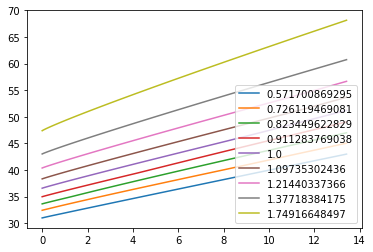

In [13]:
for i in range(0,9):
    plt.plot(kvec,V2[i],label=str(z_grid[i]))
plt.legend()
plt.show()

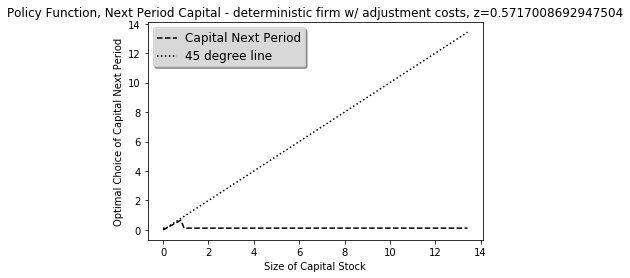

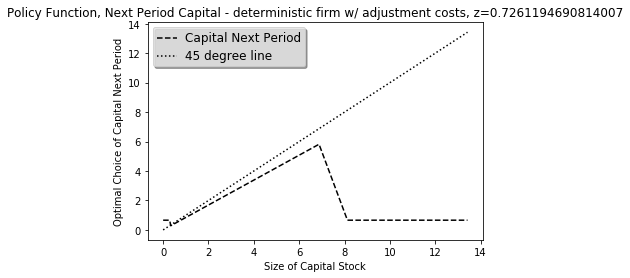

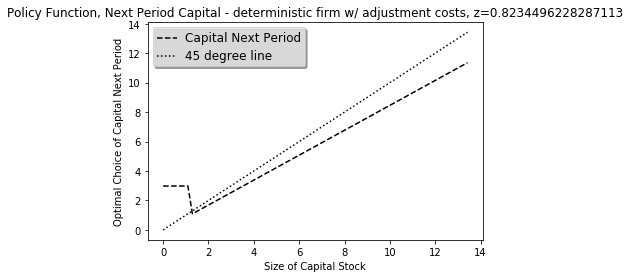

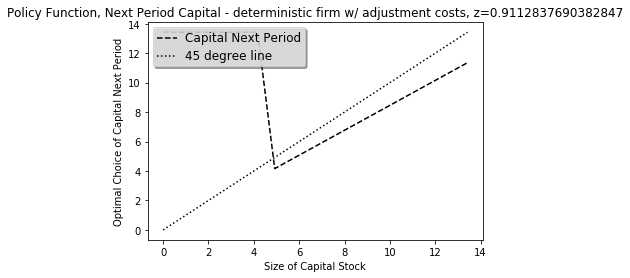

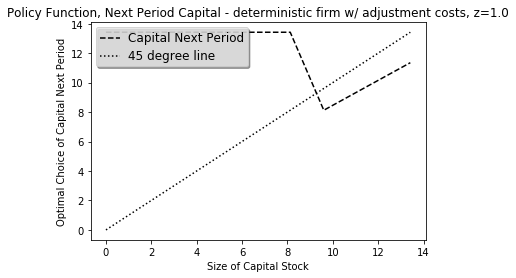

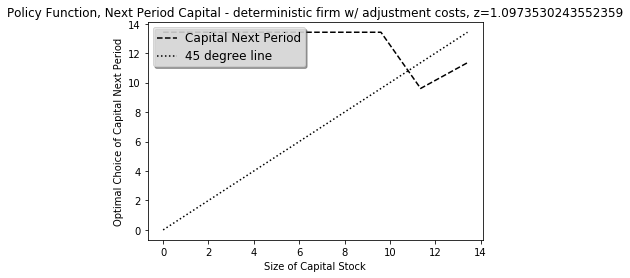

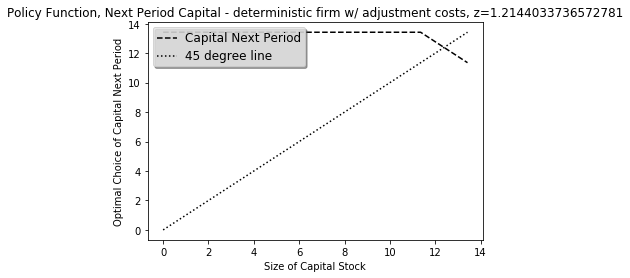

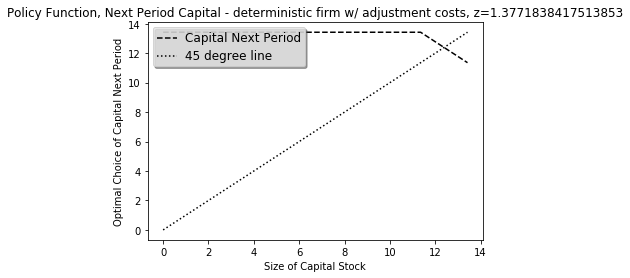

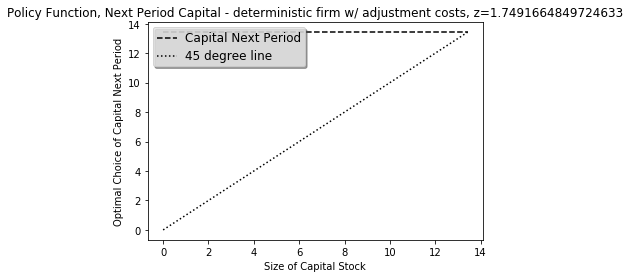

In [18]:
# Plot optimal capital stock rule as a function of firm size
for i in range(len(z_grid)):
    fig, ax = plt.subplots()
    ax.plot(kvec, kvec[PF2[i].astype(np.int)], 'k--', label='Capital Next Period')
    ax.plot(kvec, kvec, 'k:', label='45 degree line')
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper left', shadow=True)
    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')
    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Choice of Capital Next Period')
    plt.title('Policy Function, Next Period Capital - deterministic firm w/ ' +
              'adjustment costs, z={}'.format(z_grid[i]))

Since there is no penalty for investing large amounts all at once, it is logical that the firm will either invest all or nothing of what it has. Their breaking point is conditional on the productivity shock for the current period, or z. For large positive productivity shocks, they will require a greater capital stock before they decide to hedge and not invest anything.